In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [20]:
import os
print(os.environ['GOOGLE_API_KEY'][:10]+'*'*10)

AIzaSyC06D**********


In [3]:
from langchain_teddynote import logging

logging.langsmith("Naive RAG TEST")

LangSmith 추적을 시작합니다.
[프로젝트명]
Naive RAG TEST


In [7]:
# from langchain_core.prompts import ChatPromptTemplate
# from langchain import hub

# prompt_txt = """
# You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
# Your primary mission is to answer questions based on provided context or chat history.
# Ensure your response is concise and directly addresses the question without any additional narration.

# ###

# You may consider the previous conversation history to answer the question.

# # Here's the previous conversation history:
# {chat_history}

# ###

# Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

# # Steps

# 1. Carefully read and understand the context provided.
# 2. Identify the key information related to the question within the context.
# 3. Formulate a concise answer based on the relevant information.
# 4. Ensure your final answer directly addresses the question.
# 5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the answer is based on previous conversation or if the source cannot be found.

# # Output Format:
# [Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

# **Source**(Optional)
# - (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if the answer is based on previous conversation or can't find the source.)
# - (list more if there are multiple sources)
# - ...

# ###

# Remember:
# - It's crucial to base your answer solely on the **provided context** or **chat history**. 
# - DO NOT use any external knowledge or information not present in the given materials.
# - If a user asks based on the previous conversation, but if there's no previous conversation or not enough information, you should answer that you don't know.

# ###

# # Here is the user's question:
# {question}

# # Here is the context that you should use to answer the question:
# {context}

# # Your final answer to the user's question:
# """

# prompt = ChatPromptTemplate.from_template(prompt_txt)
# hub.push("naive_rag_gemni", prompt)

In [4]:
from langchain_core.prompts import load_prompt
from langchain_core.output_parsers import StrOutputParser
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

from abc import ABC, abstractmethod
from operator import itemgetter
from langchain import hub


class RetrievalChain(ABC):
    def __init__(self):
        self.source_uri = None
        self.k = 10

    @abstractmethod
    def load_documents(self, source_uris):
        """loader를 사용하여 문서를 로드합니다."""
        pass

    @abstractmethod
    def create_text_splitter(self):
        """text splitter를 생성합니다."""
        pass

    def split_documents(self, docs, text_splitter):
        """text splitter를 사용하여 문서를 분할합니다."""
        return text_splitter.split_documents(docs)

    def create_embedding(self):
        return OllamaEmbeddings(model="bge-m3")
    
    def create_embdding_eng(self):
        return GoogleGenerativeAIEmbeddings(model="text-embedding-004")

    def create_vectorstore(self, split_docs, inlang = "ko"):
        if inlang == "ko":
            return FAISS.from_documents(
                documents=split_docs, embedding=self.create_embedding()
            )
        elif inlang == "eng":
            return FAISS.from_documents(
                documents=split_docs, embedding=self.create_embdding_eng()
            )

    def create_retriever(self, vectorstore):
        # MMR을 사용하여 검색을 수행하는 retriever를 생성합니다.
        dense_retriever = vectorstore.as_retriever(
            search_type="similarity", search_kwargs={"k": self.k}
        )
        return dense_retriever

    def create_model(self):
        # return ChatOllama(model_name="dnotitia/dna", temperature=0)
        return ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

    def create_prompt(self):
        return hub.pull("naive_rag_gemni")

    @staticmethod
    def format_docs(docs):
        return "\n".join(docs)

    def create_chain(self, inlang = "ko"):
        docs = self.load_documents(self.source_uri)
        text_splitter = self.create_text_splitter()
        split_docs = self.split_documents(docs, text_splitter)
        self.vectorstore = self.create_vectorstore(split_docs, inlang)
        self.retriever = self.create_retriever(self.vectorstore)
        model = self.create_model()
        prompt = self.create_prompt()
        self.chain = (
            {
                "question": itemgetter("question"),
                "context": itemgetter("context"),
                "chat_history": itemgetter("chat_history"),
            }
            | prompt
            | model
            | StrOutputParser()
        )
        return self

In [5]:
from langchain_community.document_loaders import PDFPlumberLoader, PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List, Annotated


class PDFRetrievalChain(RetrievalChain):
    def __init__(self, source_uri: Annotated[str, "Source URI"]):
        self.source_uri = source_uri
        self.k = 10

    def load_documents(self, source_uris: List[str]):
        docs = []
        for source_uri in source_uris:
            # loader = PDFPlumberLoader(source_uri)
            loader = PyPDFLoader(source_uri)
            docs.extend(loader.load())

        return docs

    def create_text_splitter(self):
        return RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

In [7]:
# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["../data/Domain-specialized-LLM-Financial-fine-tuning-and-utilization-method-using-Mistral-7B.pdf"]).create_chain(inlang="ko")

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

In [15]:
search_result = pdf_retriever.invoke("최근의 PEFT 파인튜닝 방법들은?")
print('\n\n'.join([doc.page_content for doc in search_result]))

최근의 PEFT 파인튜닝 방법으로는 Prompt 
modification, Adapter methods, Parameterization 으
로 분류하고 있다 . Prompt modification 은 Hard 
prompt tuning 과 Soft prompt tuning, Prefix-tuning 이 
있다. Adapter methods 는 LLaMA-Adapter 등이 
있으며 Adapter를 통한 PEFT로 전체 모델의 파인
튜닝 부작용을 최소화하기 위해 모듈화한 파라
미터를 <그림 6>과 같이 추가 삽입하여 학습한다 . 
하나의 Adapter 모듈은 Bottleneck Layer 를 중심
으로 Down-projection 과 Up-projection 의 선형변
환을 수행하고 파인튜닝 과정에서 Pre-trained LLM
은 Frozen된다.
<그림 6> Adapter methods

대해 사전 학습되며 파인튜닝 , In-context learning, 
Zero/one/few-shot learning 같은 기술을 사용한다
(Dilmegani, 2023). 사전학습 후에는 모델 성능을 
측정하기 위한 학습 데이터 세트로 사용되지 않은 
테스트 데이터 세트에서 모델을 평가하고 평가 결과에 따라 모델의 성능을 향상시키기 위해 하
이퍼파라미터를 조정하거나 , 아키텍처를 변경하
거나, 추가 데이터에 대한 교육을 통해 일부 파인
튜닝을 한다 (정천수 , 2023d). 이렇게 파인튜닝 된 
언어 모델 (Fine-tuned Language Model, FLM) 은 
다양한 도메인 특화된 소규모 언어 모델 (SLM)로 
활용된다 .
2.2.1. 최신 파인튜닝 (Fine Tuning)
최근의 PEFT 파인튜닝 방법으로는 Prompt 
modification, Adapter methods, Parameterization 으

들을 Full Fine-tuning 을 하기에는 컴퓨팅 소스가 
매우 크기 때문에 LoRA와 같이 기존의 Pre-trained 
Layer의 가중치는

In [17]:
# 검색 결과를 기반으로 답변을 생성합니다.
answer = pdf_chain.invoke(
    {
        "question": "최근의 PEFT 파인튜닝 방법들은?",
        "context": search_result,
        "chat_history": [],
    }
)
print(answer)

최근의 PEFT 파인튜닝 방법은 Prompt modification, Adapter methods, Parameterization으로 분류됩니다. Prompt modification에는 Hard prompt tuning, Soft prompt tuning, Prefix-tuning이 있습니다. Adapter methods에는 LLaMA-Adapter 등이 있습니다.
**Source**
- ../data/Domain-specialized-LLM-Financial-fine-tuning-and-utilization-method-using-Mistral-7B.pdf (page 9)


In [10]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

In [11]:
def format_docs(docs):
    return "\n".join(
        [
            f"<document><content>{doc.page_content}</content><source>{doc.metadata['source']}</source><page>{int(doc.metadata['page'])+1}</page></document>"
            for doc in docs
        ]
    )


def format_searched_docs(docs):
    return "\n".join(
        [
            f"<document><content>{doc['content']}</content><source>{doc['url']}</source></document>"
            for doc in docs
        ]
    )


def format_task(tasks):
    # 결과를 저장할 빈 리스트 생성
    task_time_pairs = []

    # 리스트를 순회하면서 각 항목을 처리
    for item in tasks:
        # 콜론(:) 기준으로 문자열을 분리
        task, time_str = item.rsplit(":", 1)
        # '시간' 문자열을 제거하고 정수로 변환
        time = int(time_str.replace("시간", "").strip())
        # 할 일과 시간을 튜플로 만들어 리스트에 추가
        task_time_pairs.append((task, time))

    # 결과 출력
    return task_time_pairs


In [12]:
from langchain_teddynote.messages import messages_to_history


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return {"context": retrieved_docs}


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

In [13]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

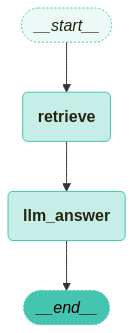

In [14]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [16]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="최근의 PEFT 파인튜닝 방법들은?")

# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>최근의 PEFT 파인튜닝 방법으로는 Prompt 
modification, Adapter methods, Parameterization 으
로 분류하고 있다 . Prompt modification 은 Hard 
prompt tuning 과 Soft prompt tuning, Prefix-tuning 이 
있다. Adapter methods 는 LLaMA-Adapter 등이 
있으며 Adapter를 통한 PEFT로 전체 모델의 파인
튜닝 부작용을 최소화하기 위해 모듈화한 파라
미터를 <그림 6>과 같이 추가 삽입하여 학습한다 . 
하나의 Adapter 모듈은 Bottleneck Layer 를 중심
으로 Down-projection 과 Up-projection 의 선형변
환을 수행하고 파인튜닝 과정에서 Pre-trained LLM
은 Frozen된다.
<그림 6> Adapter methods</content><source>../data/Domain-specialized-LLM-Financial-fine-tuning-and-utilization-method-using-Mistral-7B.pdf</source><page>10</page></document>
<document><content>대해 사전 학습되며 파인튜닝 , In-context learning, 
Zero/one/few-shot learning 같은 기술을 사용한다
(Dilmegani, 2023). 사전학습 후에는 모델 성능을 
측정하기 위한 학습 데이터 세트로 사용되지 않은 
테스트 데이터 세트에서 모델을 평가하고 평가 결과에 따라 모델의 성능을 향상시키기 위해 하
이퍼파라미터를 조정하거나 , 아키텍처를 변경하
거나, 추가 데이터에 대한 교육을 통해 일부 파인
튜닝을 한다 (정천수 , 2023d). 이렇게 파인튜닝 된 
언어 모

In [18]:
# 그래프를 스트리밍 출력
stream_graph(app, inputs, config)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
최근의 PEFT 파인튜닝 방법은 Prompt modification, Adapter methods, Parameterization으로 분류되며, Prompt modification에는 Hard prompt tuning, Soft prompt tuning, Prefix-tuning이 있다. Adapter methods의 예시로는 LLaMA-Adapter가 있다.

**Source**
- ../data/Domain-specialized-LLM-Financial-fine-tuning-and-utilization-method-using-Mistral-7B.pdf(page 10)

In [19]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 최근의 PEFT 파인튜닝 방법들은?
Answer:
최근의 PEFT 파인튜닝 방법은 Prompt modification, Adapter methods, Parameterization으로 분류되며, Prompt modification에는 Hard prompt tuning, Soft prompt tuning, Prefix-tuning이 있다. Adapter methods의 예시로는 LLaMA-Adapter가 있다.

**Source**
- ../data/Domain-specialized-LLM-Financial-fine-tuning-and-utilization-method-using-Mistral-7B.pdf(page 10)
